<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Modeling-an-entraining-cloud-updraft" data-toc-modified-id="Modeling-an-entraining-cloud-updraft-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling an entraining cloud updraft</a></span><ul class="toc-item"><li><span><a href="#Find-the-derivatives-wrt-time-of-each-of-the-4-variables" data-toc-modified-id="Find-the-derivatives-wrt-time-of-each-of-the-4-variables-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Find the derivatives wrt time of each of the 4 variables</a></span></li><li><span><a href="#Find-the-buoyancy-from-the-cloud-and-environment-$\theta_e$-and-$r_T$" data-toc-modified-id="Find-the-buoyancy-from-the-cloud-and-environment-$\theta_e$-and-$r_T$-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Find the buoyancy from the cloud and environment $\theta_e$ and $r_T$</a></span></li><li><span><a href="#Integrator" data-toc-modified-id="Integrator-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Integrator</a></span></li><li><span><a href="#Read-in-a-sounding-to-set-the-environment" data-toc-modified-id="Read-in-a-sounding-to-set-the-environment-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Read in a sounding to set the environment</a></span></li><li><span><a href="#Do-the-integration" data-toc-modified-id="Do-the-integration-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Do the integration</a></span></li></ul></li></ul></div>

# Modeling an entraining cloud updraft

This notebook shows how to calculate the time evolution of four variables:

\[velocity, height, $\theta_{ecld}$, $r_{Tcld}$ \]

in a rising cloud

In [1]:
"""
model a bulk entraining plume with constant entrainment rate
"""
import numpy as np
import pandas as pd
from pprint import pformat
from a405.thermo.constants import constants as c
from a405.thermo.thermlib import find_Tmoist,find_thetaep,find_rsat,tinvert_thetae
from scipy.interpolate import interp1d
from a405.soundings.wyominglib import write_soundings, read_soundings
import json


from scipy.integrate import ode
import matplotlib.pyplot as plt
from a405.skewT.nudge import nudge

## Find the derivatives wrt time of each of the 4 variables

See [entrain.pdf](http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/entrain.pdf)

In [2]:
def derivs(t, y, entrain_rate, interpTenv, interpTdEnv, interpPress):
    """Function that computes derivative vector for ode integrator
       see http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/entrain.pdf for equations

    Parameters
    ----------
    
    t: float
       time (s)
    y: vector
       4-vector containing wvel (m/s), height (m), thetae (K), rT (kg/kg)
    entrain_rate: float
                  1/m dm/dt (s-1)
    interpTenv: func
                interp1d function for environmental temperature T(z) 
    interpTdEnv: func
                interp1d function for environmental dewpoint temperature Td(z)
    interpPress: func
                interp1d function for presusure  p(z)

    Returns
    -------

    yp: vector
       4-vector containing time derivatives of wvel (m/s^2), height (m/s), thetae (K/s), rT (kg/kg/s)
    """
    yp = np.zeros((4,1),dtype=np.float)
    velocity = y[0]
    height = y[1]
    thetae_cloud = y[2]
    rT_cloud = y[3]
    #yp[0] is the acceleration, in this case the buoyancy 
    yp[0] = calcBuoy(height, thetae_cloud, interpTenv, interpTdEnv, interpPress)
    press = interpPress(height)*100. #Pa
    Tdenv = interpTdEnv(height) + c.Tc #K
    Tenv = interpTenv(height) + c.Tc #K
    rTenv = find_rsat(Tdenv, press) #kg/kg
    thetaeEnv = find_thetaep(Tdenv, Tenv, press)
    #yp[1] is the rate of change of height
    yp[1] = velocity
    #yp[2] is the rate of change of thetae_cloud
    yp[2] = entrain_rate*(thetaeEnv - thetae_cloud)
    #yp[3] is the rate of change of rT_cloud
    yp[3] = entrain_rate*(rTenv - rT_cloud)
    return yp

## Find the buoyancy from the cloud and environment $\theta_e$ and $r_T$

In [3]:
def calcBuoy(height, thetae0, interpTenv, interpTdEnv, interpPress):
    """function to calculate buoyant acceleration for an ascending saturated parcel
       this version neglects liquid water loading
    
    Parameters
    ----------
    
    height: float
            parcel height (m)
    thetae0: float
            parcel thetae (K)

    interpTenv: func
                interp1d function for environmental temperature T(z) 
    interpTdEnv: func
                interp1d function for environmental dewpoint temperature Td(z)
    interpPress: func
                interp1d function for presusure  p(z)

    Returns
    -------

    buoy: float
          buoyancy (m/s/s)
    """
    #input: height (m), thetae0 (K), plus function handles for
    #T,Td, press soundings
    #output: Bout = buoyant acceleration in m/s^2
    #neglect liquid water loading in the virtual temperature
    
    press=interpPress(height)*100.#%Pa
    Tcloud=find_Tmoist(thetae0,press) #K
    rvcloud=find_rsat(Tcloud,press); #kg/kg
    Tvcloud=Tcloud*(1. + c.eps*rvcloud)
    Tenv=interpTenv(height) + c.Tc
    Tdenv=interpTdEnv(height) + c.Tc
    rvenv=find_rsat(Tdenv,press); #kg/kg
    Tvenv=Tenv*(1. + c.eps*rvenv)
    TvDiff=Tvcloud - Tvenv
    buoy = c.g0*(TvDiff/Tvenv)
    return buoy



## Integrator 

Use http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html to integrate our system of 4 odes 

In [4]:
def integ_entrain(df_sounding,entrain_rate):
    """integrate an ascending parcel given a constant entrainment rate
       this version hardwired to start parcel at 800 hPa with cloud base
       values of environment at 900 hPa

    Parameters
    ----------

    df_sounding: pandas dataframe 
               : cloumns are temperature, dewpoint, height, press

    entrain_rate: float
                  1/m dm/dt (s-1)

    Returns
    -------

    df_out: dataframe
          dataframe containing wvel (m/s) ,cloud_height (m) , thetae (K), rT (kg/kg) for assending parcel

   interpPress: func
              interp1d function for presusure  p(z) (used for plotting)
    """
    press = df_sounding['pres'].values
    height = df_sounding['hght'].values
    temp = df_sounding['temp'].values
    dewpoint = df_sounding['dwpt'].values
    envHeight= nudge(height)

    interpTenv = interp1d(envHeight,temp)
    interpTdEnv = interp1d(envHeight,dewpoint)
    interpPress = interp1d(envHeight,press)
    #
    # call this cloudbase
    #
    p900_level = len(press) - np.searchsorted(press[::-1],900.)
    thetaeVal=find_thetaep(dewpoint[p900_level] + c.Tc,temp[p900_level] + c.Tc,press[p900_level]*100.)
    rTcloud = find_rsat(dewpoint[p900_level] + c.Tc, press[p900_level]*100.)
    #
    # start parcel here
    #
    p800_level = len(press) - np.searchsorted(press[::-1],800.)
    height_800=height[p800_level]
    winit = 0.5 #initial velocity (m/s)
    yinit = [winit, height_800, thetaeVal, rTcloud]  
    tinit = 0  #seconds
    tfin = 2500  #seconds
    dt = 10   #seconds

    #want to integrate derivs using dopr15 runge kutta described at
    # http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html
    #
    r = ode(derivs).set_integrator('dopri5')
    r.set_f_params(entrain_rate, interpTenv, interpTdEnv, interpPress)
    r.set_initial_value(yinit, tinit)
    
    #the while loop below  integrates every dt seconds
    #we stop tracking the parcel when the time runs out, or if the parcel stops moving/is desecnding
    #
    var_out = []
    time_out =[]
    while r.successful() and r.t < tfin and r.y[0] > 0:
        #find y at the next time step
        #(r.integrate(t) updates the fields r.y and r.t so that r.y = integral of derivs(t) and r.t = time 
        #where derivs is a vector with the variables to be integrated
        #
        # move ahead by dt
        #
        r.integrate(r.t+dt)
        #
        # stop if there is negative vertical velocity
        #
        if r.y[0] <= 0:
            break
        #
        #save values for dataframe
        #
        var_out.append(r.y)
        time_out.append(r.t)
    #
    # convert the output into a datafram
    #
    colnames=['wvel','cloud_height','thetae_cloud','rT_cloud']
    df_out=pd.DataFrame.from_records(var_out,columns=colnames)
    df_out['time'] = time_out
    return df_out,interpPress



## Read in a sounding to set the environment

In [5]:
def get_sounding(get_data=True,soundingdir='littlerock',soundingfile='littlerock.csv',
                 metafile='littlerock.json',values=None,the_time=None):
    """
    Parameters
    ----------
    
    get_data: bool
        set to False to read from an existing soundingfile
    soundingdir: string
        name of folder for retrieved soundings
    sondingfile: string
        name of csv file that holds sounding for this run
    metafile:  string
        name of json file that holds sounding metadata for this run
    values:  dict
        dictionary containing parameters needed by a405.soundings.wyominglib.write_soundings
    the_time: tuple
        (year, month, day, hour) tuple for sounding for current run
        
    Returns
    -------
    
    sounding: Dataframe
       pandas dataframe with sounding columns
    attributes: dict
       dictionary with sounding metadata
    """
    if get_data:
        if values is None:
            values=dict(region='naconf',year='2012',month='7',start='0100',
                        stop='3000',station='72340')
            the_time=(2012,7,17,0)
        write_soundings(values, soundingdir)
        soundings= read_soundings(soundingdir)
        sounding=soundings['sounding_dict'][the_time]
        sounding.to_csv(soundingfile)
        title_string=soundings['attributes']['header']
        index=title_string.find(' Observations at')
        location=title_string[:index]
        print(f'location: {location}')
        units=soundings['attributes']['units'].split(';')
        units_dict={}
        for count,var in enumerate(sounding.columns[1:]):
            units_dict[var]=units[count]
        soundings['attributes']['location']=location
        soundings['attributes']['units']=units
        soundings['attributes']['time']=the_time
        soundings['attributes']['history']='written by entraining_plume notebook'
        with open(metafile,'w') as outfile:
            json.dump(soundings['attributes'],outfile,indent=4)
        attributes=soundings['attributes']
    else:
        sounding = pd.read_csv(soundingfile)
        with open(metafile,'r') as infile:
            attributes=json.load(infile)
    return sounding,attributes



## Do the integration

In [6]:
df_sounding,attributes = get_sounding(get_data=False)

In [7]:
entrain_rate = 2.e-4
df_result, interpPress=integ_entrain(df_sounding,entrain_rate)

/Users/phil/repos/atsc405_2018/a405/thermo/thermlib.py:441: RuntimeWarning: invalid value encountered in log
  s = cp * np.log(T) - c.Rd * np.log(pd) + lv * rv / T - vapor_term


In [8]:
df_result

,wvel,cloud_height,thetae_cloud,rT_cloud,time
0,1.004138,2141.524836,351.833846,0.015515,10.0
1,1.502372,2154.063088,351.812822,0.015505,20.0
2,1.994777,2171.548389,351.791952,0.015495,30.0
3,2.501768,2194.013275,351.771031,0.015485,40.0
4,3.032799,2221.663866,351.749979,0.015475,50.0
5,3.593245,2254.767289,351.728764,0.015465,60.0
6,4.188677,2293.645368,351.707353,0.015454,70.0
7,4.824890,2338.676742,351.685717,0.015444,80.0
8,5.507923,2390.299207,351.663824,0.015433,90.0
9,6.244076,2449.012201,351.641648,0.015422,100.0


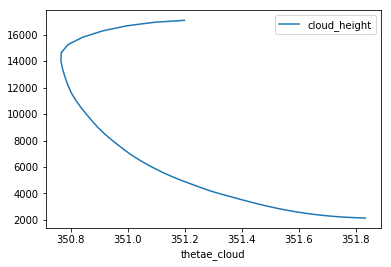

In [10]:
df_result.plot('thetae_cloud','cloud_height')